# Using pixel intensity thresholding to segment the entire mosquito antennal lobe (AL)

This notebook is kept tidy by modularizing the data and code into separate python files that are imported here.

See `experiment_info.py` to specify important details related to the experiment. Within this file, important information gets stored in the `params` dictionary.

If you have different experiments, simply store the information in a separate python file and change the name `experiment_info` in the cell below to correspond to the file with the information from this other experiment.

**NOTES**: 
- There should be as many .tif videos as there are odors, and it is assumed that these videos are alphanumerically labeled in the same order as they appear in `odor_string`. I.e., if we sort the names of the videos, the first one should correspond to the first odor in `odor_string`.
- For computational speed, this code should be run wherever the raw data are stored. If you mount the file system where the data are stored (e.g. PNI cluster) and run the code on your local machine, it may go very slow as the data has to transfer over the network. I currently use this notebook for interactive work, but when I'm satisfied with the results for a few samples, I export this notebook as a python script using `jupyter nbconvert --to script 01_segment_and_extract_traces.ipynb` and then execute this script as a job using SLURM.

### First: specify odors to analyze
These odors should correspond to the values in the `odor_encodings` dictionary specified in `experiment_info.py`.

If you want to analyze ALL odors, leave this list blank `[]`. Fow now, I suggest keeping this black and analyzing all odors.

In [1]:
odors_of_interest = []

### make directory to store results

In [2]:
results_dir = 'results'
import os
os.makedirs(results_dir, exist_ok=True)

### Load in `experiment_info.py` along with `functions.py`, which has some custom functions used here. 

In [3]:
# import important experimental variables
from experiment_info import samples, data_dir
from experiment_info import odor_encodings, odor_string
from experiment_info import params
# import custom functions
import functions as fn

print(f'data directory: {data_dir}')
print(f'Number of samples: {len(samples)}')
odor_list = odor_string.split('_')
num_odors = len(odor_list)

# make a dictionary to store the order in which odors are presented
odor_order = {}
for i,odor in enumerate(odor_list):
    odor_name = odor_encodings[odor]
    if odor_name not in odor_order:
        odor_order[odor_name] = i

print(f'Number of odors: {num_odors}')
print(f'x,y,z dimensions:', params['x_dim'], params['y_dim'], params['z_dim'])
print(f'Number of frames to analyze:', params['n_frames_to_analyze'])
print(f'Number of initial frames for df/f normalization:', params['background_frames'])

# sanity checks
assert os.path.isdir(data_dir), f'Data directory does not exist: {data_dir}'
for samp in samples:
    assert os.path.isdir(f"{data_dir}/{samp}"), f"directory {data_dir}/{samp} containing tif files does not exist! Is there one approppriately-named subdirectory per sample?"
for odor in odor_list:
    assert odor in odor_encodings, f"Odor {odor} in odor_list not found in odor_encodings dictionary. Please add it to experiment_info.py"
for o in odors_of_interest:
    assert o in odor_encodings.values(), f"Odor {o} in odors_of_interst not found in odor_encodings dictionary"


2024-05-23 13:46:19.157670: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 13:46:19.157740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 13:46:19.159224: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


data directory: /jukebox/mcbride/bjarnold/new_analysis/data/Mar_22_2024/1_RegisteredBrains
Number of samples: 2
Number of odors: 72
x,y,z dimensions: 128 128 24
Number of frames to analyze: 112
Number of initial frames for df/f normalization: 20


### Import other libraries

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
import glob
import pandas as pd
from collections import defaultdict
import caiman as cm
import pickle


### Get full file paths for all videos, per sample.
Note that this finds **all** videos per sample. We potentially select a subset of these later on.

In [5]:
videos = {}
for samp in samples:
    v = glob.glob(f"{data_dir}/{samp}/*.tif")
    v = sorted(v)
    num_vids = len(v)
    assert num_vids == num_odors, f"I found {num_vids} videos for sample {samp}, but there are {num_odors} odors. The number of videos and odors should be equivalent."
    videos[samp] = v

### Find indices of videos corresponding to odors specified in `odors_of_interest`. To do this, we will use the order of odors specified in `odor_string` and assume the ordering of videos is the same.

In [6]:
odor_of_interest_indices = []
if odors_of_interest:
    for i,odor in enumerate(odor_list):
        if odor_encodings[odor] in odors_of_interest:
            # print(i, odor, odor_encodings[odor])
            odor_of_interest_indices.append(i)
else:
    odor_of_interest_indices = list(range(len(odor_list)))
assert odor_of_interest_indices == sorted(odor_of_interest_indices), "odor_of_interest_indices should be sorted"
print(f"According to your odors of interest, I was able to find this many in the odor_list: {len(odor_of_interest_indices)}") 
# print("for first sample in list, get the name of files with this odor:")
# tmp = [videos[samples[0]][i].split('/')[-1] for i in odor_of_interest_indices]
# for i in tmp:
#     print(i)

According to your odors of interest, I was able to find this many in the odor_list: 72


### For each sample, concatenate all videos (one per odor) and threshold to segment AL.
For thresholding, we are currently using `ski.filters.threshold_otsu`

In [7]:
# data reloaded to ensure cell runs independently
binary_masks = {}
for samp in videos:
    Y_list = fn.load_videos_into_list(videos[samp], odor_of_interest_indices, params, normalize=False)
    Y = cm.concatenate(Y_list)

    binary_mask = fn.find_binary_mask(Y)
    print(f"fraction of volume containing AL segment for sample {samp}: ", np.sum(binary_mask)/(params['x_dim']*params['y_dim']*params['z_dim']))
    binary_masks[samp] = binary_mask


fraction of volume containing AL segment for sample 230913_ORL_GCaMP6f_F2:  0.12050120035807292
fraction of volume containing AL segment for sample 230914_ORL_GCaMP6f_F2:  0.09933725992838542


### Save binary masks to use in downstream analyses

In [8]:
with open(f'{results_dir}/binary_masks.pkl', 'wb') as f:
    pickle.dump(binary_masks, f)

## Look at 2D projections of 3D binary masks
Check out all the .png files that get created in the `binary_mask_plots` subdirectory in results_dir.

In [9]:
os.makedirs(f'{results_dir}/binary_mask_plots', exist_ok=True)
colors = [(0, 0, 0, 0), (0, 0, 0, 0.1)]  # RGBA tuples, the 1st color's alpha set to 0 to make transparent so white values are ignores, black values are partially transparent; 0's mapped to 1st color, 1's mapped to 2nd color
cmap = ListedColormap(colors)

for i,samp in enumerate(samples):
    fig, ax = plt.subplots(1,1, figsize=(3,3))
    for i in range(0,params['z_dim']):
        plt.imshow(binary_masks[samp][:,:,i], cmap=cmap)
    plt.title(samples[0])
    sns.despine()
    plt.savefig(f'{results_dir}/binary_mask_plots/{samp}_binary_mask.png', dpi=300)
    plt.close()


### Within each AL segment, compute mean activity over time

In [10]:
mean_activity_within_segment = {}
for i,samp in enumerate(videos):
    Y_list = fn.load_videos_into_list(videos[samp], odor_of_interest_indices, params, normalize=True) # note normalize = True!
    Y = cm.concatenate(Y_list)
    mean_activity_within_segment[samp] = fn.extract_mean_activity_within_binary_mask(Y, binary_masks[samp], params)
    print(f'finished sample {i+1}')


finished sample 1
finished sample 2


### Subtract the paraffin signal from each trace

In [11]:
mean_activity_within_segment_paraffin_subtracted = fn.subtract_paraffin_trace(mean_activity_within_segment, odor_of_interest_indices, odor_list, odor_encodings, params['n_frames_to_analyze'])

### Save trace results

In [12]:
mean_activity_df = pd.DataFrame.from_dict(mean_activity_within_segment)
mean_activity_df.to_csv(f'{results_dir}/mean_activity_within_segment.csv', index=False)

mean_activity_paraffin_subtracted_df = pd.DataFrame.from_dict(mean_activity_within_segment_paraffin_subtracted)
mean_activity_paraffin_subtracted_df.to_csv(f'{results_dir}/mean_activity_within_segment_paraffin_subtracted.csv', index=False)


## Plot activity traces

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(16, 4))

for i,samp in enumerate(mean_activity_within_segment):    
    plt.plot(mean_activity_within_segment[samp] + i*0.02, c='black')  # Offset each trace by i*3
    # print sample name on the right
    plt.text(len(mean_activity_within_segment[samp])*1.02, i*0.02, samp, color='black')

# print the names of the odors on the x-axis
odor_names = []
positions = []
for i,index in enumerate(odor_of_interest_indices):
    odor_names.append(odor_encodings[odor_list[index]])
    positions.append(i*params['n_frames_to_analyze'] + params['n_frames_to_analyze']/2)
plt.xticks(positions, odor_names, rotation=90)

# draw vertical lines to separate odors
for i in range(len(odor_of_interest_indices)):
    plt.axvline((i+1)*params['n_frames_to_analyze'], color="black", linestyle="--", alpha=0.1)

plt.yticks([])
# supress grid lines
plt.grid(False)
sns.despine()

plt.savefig(f'{results_dir}/signal_traces.png', dpi=300)
plt.close()


## For each odor, using the mean activity traces, get the maximum intensity during the frames corresponding to that odor.

While were at it, let's also get the exact frame in which the segment was at it's max activity and store in the `argmaxs_by_samp` dictionary.

In [14]:
# # reload the functions module to make sure we are using the latest version
# import importlib
# importlib.reload(fn)

maxs_by_samp, argmaxs_by_samp = fn.compute_max_responses(mean_activity_within_segment, odor_of_interest_indices, odor_list, odor_encodings, params['n_frames_to_analyze'])
aucs_by_samp = fn.calculate_AUC(mean_activity_within_segment, odor_of_interest_indices, odor_list, odor_encodings, params, test=False)

## From the mean activity in each segment, subtract out the activity observed from the paraffin odor (negative control)

In [16]:
mean_activity_within_segment_paraffin_subtracted = fn.subtract_paraffin_trace(mean_activity_within_segment, odor_of_interest_indices, odor_list, odor_encodings, params['n_frames_to_analyze'])

## Plot the traces that have had the paraffin signal subtracted

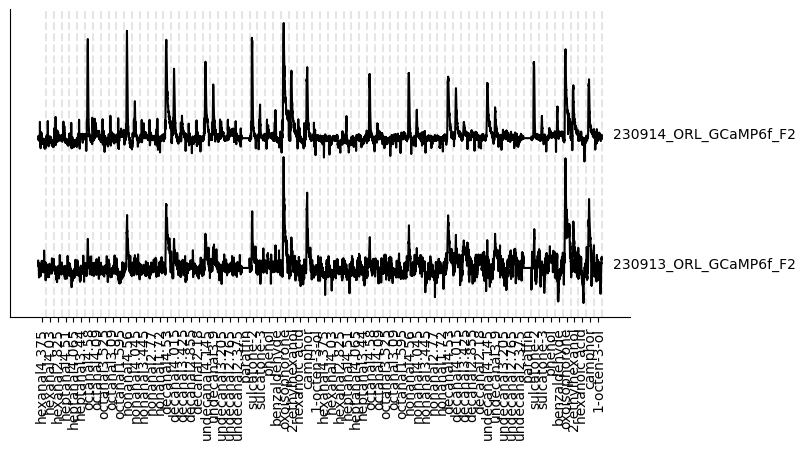

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

for i,samp in enumerate(mean_activity_within_segment_paraffin_subtracted):    
    plt.plot(mean_activity_within_segment_paraffin_subtracted[samp] + i*0.02, c='black')  # Offset each trace by i*3
    # print sample name on the right
    plt.text(len(mean_activity_within_segment_paraffin_subtracted[samp])*1.02, i*0.02, samp, color='black')

# print the names of the odors on the x-axis
odor_names = []
positions = []
for i,index in enumerate(odor_of_interest_indices):
    odor_names.append(odor_encodings[odor_list[index]])
    positions.append(i*params['n_frames_to_analyze'] + params['n_frames_to_analyze']/2)
plt.xticks(positions, odor_names, rotation=90)

# draw vertical lines to separate odors
for i in range(len(odor_of_interest_indices)):
    plt.axvline((i+1)*params['n_frames_to_analyze'], color="black", linestyle="--", alpha=0.1)

plt.yticks([])
# supress grid lines
plt.grid(False)
sns.despine()

In [26]:
maxs_by_samp_paraffin_subtracted, _ = fn.compute_max_responses(mean_activity_within_segment_paraffin_subtracted, odor_of_interest_indices, odor_list, odor_encodings, params['n_frames_to_analyze'])
aucs_by_samp_paraffin_subtracted = fn.calculate_AUC(mean_activity_within_segment_paraffin_subtracted, odor_of_interest_indices, odor_list, odor_encodings, params)

## Convert the data to a DataFrame and save

In [27]:
def convert_to_df(dict, odor_order):
    df_list = []
    for samp in dict:
        df_tmp = pd.DataFrame.from_dict(dict[samp])
        df_tmp['samp'] = samp
        df_tmp['subpop'] = samp.split('_')[1]
        df_tmp['trial'] = df_tmp.index+1
        df_list.append(df_tmp)
    df = pd.concat(df_list)
    df = df.reset_index(drop=True)
    df = pd.melt(df, id_vars=['samp', 'subpop', 'trial'], var_name='odor', value_name='value')
    df['odor_order'] = df['odor'].map(odor_order)
    return df
    
peak_max_df = convert_to_df(maxs_by_samp, odor_order)
peak_auc_df = convert_to_df(aucs_by_samp, odor_order)

peak_max_paraffin_df = convert_to_df(maxs_by_samp_paraffin_subtracted, odor_order)
peak_auc_paraffin_df = convert_to_df(aucs_by_samp_paraffin_subtracted, odor_order)

peak_max_df.to_csv(f'{results_dir}/peak_max_df.csv', index=False)
peak_auc_df.to_csv(f'{results_dir}/peak_auc_df.csv', index=False)
peak_max_paraffin_df.to_csv(f'{results_dir}/peak_max_paraffin_df.csv', index=False)
peak_auc_paraffin_df.to_csv(f'{results_dir}/peak_auc_paraffin_df.csv', index=False)


## For each odor, get the frame corresponding to the maximum activity

-within compute_max_responses, get index of frame of max activity

-store in dict with odor_name as key, index as value

-go through each odor_of_interest_indices, get name of odor and load the video for that index

-extract frame of corresponding to index of max intensity

In [37]:
for i, index in enumerate(odor_of_interest_indices):
    # i=11 is nonanal4.56
    # i=16 is decanal5.53
    for samp in samples:
        os.makedirs(f'{results_dir}/images_at_max_intensity_per_odor/{samp}', exist_ok=True)
        # only look at the first trial; odors with indices > 36 are repeats from second trial.
        if index < 36:
            odor_name = fn.get_odor_name(index, odor_list, odor_encodings)
            frame_at_max = argmaxs_by_samp[samp][odor_name][0]
            Y = cm.load(videos[samp][index])
            Y = fn.reshape(Y, params['x_dim'], params['y_dim'], params['z_dim'])
            Y = fn.background_normalize(Y, params['background_frames'])
            Y = Y[frame_at_max]
            file_name = f'{results_dir}/images_at_max_intensity_per_odor/{samp}/{odor_name}.pkl'
            with open(file_name, 'wb') as f:
                pickle.dump(Y, f)
            # projection = np.mean(Y, axis=2)
            # fig, ax = plt.subplots(1,1, figsize=(3,3))
            # plt.imshow(projection, cmap='bone')

